# **Adding data to the Geoanalytics STAC server**

In [2]:
# We will be using Sentinel-2 L2A imagery from Microsoft Planetary Computer's STAC server:
!pip install planetary_computer
!pip install boto3
!pip install rasterio
!pip install shapely

In [3]:
import io
import os
import sys
import time
import boto3
import shapely
import getpass
import requests
import datetime
import json
import glob
import dask
import rasterio
import gcsfs
import pystac
import stackstac
import planetary_computer

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt 

from rasterio.warp import calculate_default_transform
from dask.distributed import performance_report
from shapely.geometry import Polygon, mapping, shape
from shapely.ops import unary_union
from datetime import datetime
from itertools import islice
from pystac.extensions.projection import ProjectionExtension
from pystac.extensions.eo import Band
from pystac_client import Client
from dask_gateway import Gateway
from IPython.display import clear_output
from shapely import wkt
from dateutil.parser import parse as dateparse
from urllib.request import urlopen, Request, build_opener, HTTPCookieProcessor
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from IPython.display import clear_output

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
gateway = Gateway()

# Cluster configuration 
options = gateway.cluster_options()
options.image = 'pangeo/pangeo-notebook:2022.04.15' ## need to update this to be automated

In [9]:
# cluster = gateway.new_cluster(options)
cluster = gateway.connect('pangeo.488abcac966f469ca8f6eaece214f00f')
cluster

In [17]:
# Scale the cluster
workers = 15
cluster.scale(workers) 

In [18]:
# Assign client to this cluster so Dask knows to use it for computations
client = cluster.get_client() 

In [19]:
client.wait_for_workers(workers-1)
cluster

In [10]:
gateway.list_clusters()

[ClusterReport<name=pangeo.488abcac966f469ca8f6eaece214f00f, status=RUNNING>]

## 1. Query the Sentinel 2 Data from PlanetaryComputer

In [11]:
# Create a polygon for defining our Area of Interest (AOI) in this case we are using a rough outline of Quebec City,Quebec created using: https://www.keene.edu/campus/maps/tool/
polygon ={
  "coordinates": [
    [
      [
        -71.5577316,
        46.9574391
      ],
      [
        -71.5588903,
        46.9381912
      ],
      [
        -71.5264034,
        46.9373414
      ],
      [
        -71.5258884,
        46.9588158
      ],
      [
        -71.5577316,
        46.9574391
      ]
    ]
  ],
  "type": "Polygon"
}

In [12]:
lon_list = []
lat_list = []

for lon,lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

,geometry
0,"POLYGON ((-71.55773 46.95744, -71.55889 46.938..."


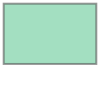

In [13]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [14]:
FOOTPRINT.bounds

(-71.5588903, 46.9373414, -71.5258884, 46.9588158)

In [15]:
def register_gcsfs_client(username:str):
    # set up the gcsfs system with credentials
    print('registering gcsfs')
    tok = os.path.join(os.environ['HOME'], f'geoanalytics_{username}', 'geo.json') # Change this to your own cred file
    tok_dict = json.load(open(tok)) # cloudpickle will just send the path to tok, which the processing nodes can't see. Send json instead
    gcs = gcsfs.GCSFileSystem(token=tok_dict, access='read_write')
    return gcs

In [16]:
username = input('Username: ')
gcs = register_gcsfs_client(username=username)

Username:  mkavlin


registering gcsfs


In [17]:
# Function to write from the dask cluster to the remote bucket
@dask.delayed
def write_ras(gcs, epsg, ras, b, pth):
    import rioxarray
    try:
        ds = xr.Dataset()
        ras = ras.rio.write_crs(epsg)
        ras.rio.to_raster('ras.tif')
        # Turn the raster into a COG
        dst_profile = cog_profiles.get("deflate")
        cog_translate(
            'ras.tif',
            'ras_cog.tif',
            dst_profile,
            in_memory=True,
            quiet=False,
        )
        # Use GCSFS Client to put COG into remote bucket
        gcs.put('ras_cog.tif', pth)
        # Clean up rasters on Dask Worker
        os.remove('ras.tif')
        os.remove('ras_cog.tif')
        return 'success'
    except Exception as e:
        # Return error and associated band
        return f'{b}: {e}'

In [18]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

<Client id=microsoft-pc>

In [46]:
save_path = "gs://geoanalytics-user-shared-data/PHAC9442/example_data_stac_adding/"
local_path = f'/home/jovyan/geoanalytics_user_shared_data/PHAC9442/example_data_stac_added/'
Type = "COG"
epsg = 32618

In [19]:
# CONFIG 
# -------------
BASE_PTH = 'gs://geoanalytics-user-shared-data'
OUTPUT_DIR = 'Tutorial_stac_test'
TGT_BANDS =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
YEARS = ['2019','2020']
BEGIN_MONTH = '06'
END_MONTH = '09'
MAX_CLOUD = 100
READ_IN_CHUNK = 4096
RESOLUTION = 10
TEMPORAL_CHUNK = {'time': -1, 'band': 1, 'x': 128, 'y': 128}
SYNCHRONOUS = True # Write bands out one at a time - use if resources can't handle all bands at once for AOI
# -------------

In [71]:
# Download the data
item_dict = []
raster_list = []
json_list = []
for year in YEARS:
    OUT_PTH = f'{BASE_PTH}/{OUTPUT_DIR}/{year}'
    date_range = f'{year}-{BEGIN_MONTH}-01/{year}-{END_MONTH}-30'
    
    # Query the Planetary Computer STAC server with pystac_client
    print(f'[Querying] {year}')
    items = api.search(
        collections = ['sentinel-2-l2a'],
        intersects = FOOTPRINT,
        query={"eo:cloud_cover": {"lt": MAX_CLOUD}}, #"s2:mgrs_tile":{"eq":'10UFA'}},
        datetime = date_range,
    ).get_all_items()
    
    
    print(f'\tFound {len(items)} items')
    # planetarycomputer requires signed URLs to access Asset HREFs. 
    print('\t[Signing data links]')
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]
    item_dict+=signed_items
        # Iterate over bands and build composite DAG
    for band in TGT_BANDS:
        #clear_output(wait=True) # clear Jupyter Cell output
        print(f'[Processing {band}]')
        
    # print(signed_items)

    # Convert STAC query into a xarray.DataArray
    # with stackstac
        print('\t[Converting STAC query to DataArray]')
        data = (
            stackstac.stack(
                item_dict,
                assets=[band], 
                chunksize=READ_IN_CHUNK, # Set chunksize
                resolution=RESOLUTION, # Set all bands res to this
                bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
                epsg = 32618
            ).where(lambda x: x > 0, other=np.nan).assign_coords( # Convert nodata zero to np.nan
                #band=lambda x: x.common_name.rename("band"),  # use common names
                time=lambda x: x.time.dt.round(
                    "D"
                ))  
        )
        
        for image in data: 
            image_name = image.coords['id'].values
            print(f'Saving {image_name} to {OUT_PTH}')
            #print(image_name)
            final_Spath = f'{save_path}{image_name}'

            raster_list.append(write_ras(gcs, epsg, image, band, f'{OUT_PTH}{image_name}/{band}.tif'))
            
            
clear_output(wait=True)
# # raster_list.visualize()
# with performance_report('dask_report.html'):
#     print(dask.compute(raster_list)[0])        
# dask.compute(raster_list)
data

[Querying] 2019
	Found 88 items
	[Signing data links]
[Processing B01]
	[Converting STAC query to DataArray]
Saving S2A_MSIL2A_20190602T153911_R011_T19TCN_20201005T210749 to gs://geoanalytics-user-shared-data/Tutorial_stac_test/2019


/srv/conda/envs/notebook/lib/python3.9/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/srv/conda/envs/notebook/lib/python3.9/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))


TypeError: Object of type DataArray is not JSON serializable

In [68]:
image_list = gcs.ls('gs://geoanalytics-user-shared-data/Tutorial_stac_test')

In [73]:
# for folder in image_list:
#     for image in folder:
#         for band in TGT_BANDS:
        
#             json_file = f'{band}.json'
#             with open(json_file, 'w') as f:
#                 json.dump(image, f)
#             # Saving to GCP
#             output_path = f'{BASE_PTH}/{OUTPUT_DIR}/{band}.json'
#             gcs.put(json_file, output_path)

KeyboardInterrupt: 

In [48]:
print(pystac.Catalog.__doc__)

A PySTAC Catalog represents a STAC catalog in memory.

    A Catalog is a :class:`~pystac.STACObject` that may contain children,
    which are instances of :class:`~pystac.Catalog` or :class:`~pystac.Collection`,
    as well as :class:`~pystac.Item` s.

    Args:
        id : Identifier for the catalog. Must be unique within the STAC.
        description : Detailed multi-line description to fully explain the catalog.
            `CommonMark 0.28 syntax <https://commonmark.org/>`_ MAY be used for rich
            text representation.
        title : Optional short descriptive one-line title for the catalog.
        stac_extensions : Optional list of extensions the Catalog implements.
        href : Optional HREF for this catalog, which be set as the
            catalog's self link's HREF.
        catalog_type : Optional catalog type for this catalog. Must
            be one of the values in :class`~pystac.CatalogType`.

    Attributes:
        id : Identifier for the catalog.
        de

In [49]:
catalog = pystac.Catalog(id='S2-test-catalog', description='Tutorial catalog of Sentinel 2 imagery around Quebec City')

In [50]:
print(list(catalog.get_children()))
print(list(catalog.get_items()))

[]
[]


In [51]:
print(pystac.Item.__doc__)

An Item is the core granular entity in a STAC, containing the core metadata
    that enables any client to search or crawl online catalogs of spatial 'assets' -
    satellite imagery, derived data, DEM's, etc.

    Args:
        id : Provider identifier. Must be unique within the STAC.
        geometry : Defines the full footprint of the asset represented by this
            item, formatted according to
            `RFC 7946, section 3.1 (GeoJSON) <https://tools.ietf.org/html/rfc7946>`_.
        bbox :  Bounding Box of the asset represented by this item
            using either 2D or 3D geometries. The length of the array must be 2*n
            where n is the number of dimensions. Could also be None in the case of a
            null geometry.
        datetime : Datetime associated with this item. If None,
            a start_datetime and end_datetime must be supplied in the properties.
        properties : A dictionary of additional metadata for the item.
        stac_extensions : Opt

In [52]:
import rasterio
from shapely.geometry import Polygon, mapping

def get_bbox_and_footprint(raster_uri):
    with rasterio.open(raster_uri) as ds:
        bounds = ds.bounds
        bbox = [bounds.left, bounds.bottom, bounds.right, bounds.top]
        footprint = Polygon([
            [bounds.left, bounds.bottom],
            [bounds.left, bounds.top],
            [bounds.right, bounds.top],
            [bounds.right, bounds.bottom]
        ])

        return (bbox, mapping(footprint))

In [28]:
image_list = gcs.ls('gs://geoanalytics-user-shared-data/Tutorial_stac_test/')

In [29]:
for folder in image_list:
    for band in TGT_BANDS:
        # print(gcs.glob('gs://geoanalytics-user-shared-data/Tutorial_stac_test/**/*.tif'))
        image_path = (f'gs://{folder}/{band}.tif')
        print(image_path)
        
        
        # image_name = image
        # print(image_name)
        # bbox, footprint = get_bbox_and_footprint(image_path)
        # print (bbox)
        # print(footprint)
        # item = pystac.Item(id=image_name,
        #          geometry=footprint,
        #          bbox=bbox,
        #          datetime=datetime.utcnow(),
        #          properties={})

gs://geoanalytics-user-shared-data/Tutorial_stac_test//B01.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B02.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B03.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B04.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B05.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B06.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B07.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B08.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B09.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B11.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B12.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test//B8A.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test/.ipynb_checkpoints/B01.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test/.ipynb_checkpoints/B02.tif
gs://geoanalytics-user-shared-data/Tutorial_stac_test/.ipynb_checkpoints/B03.tif
g

In [53]:
bbox, footprint = get_bbox_and_footprint('/home/jovyan/geoanalytics_user_shared_data/Tutorial_stac_test/2019S2A_MSIL2A_20190602T153911_R011_T18TYT_20201005T210750/B01.tif')
print(bbox)
print(footprint)

[761795.0, 5203955.0, 764415.0, 5206455.0]
{'type': 'Polygon', 'coordinates': (((761795.0, 5203955.0), (761795.0, 5206455.0), (764415.0, 5206455.0), (764415.0, 5203955.0), (761795.0, 5203955.0)),)}


In [54]:
item = pystac.Item(id='local-image',
                 geometry=footprint,
                 bbox=bbox,
                 datetime=datetime.utcnow(),
                 properties={})

In [55]:
item.get_parent() is None

True

In [56]:
catalog.add_item(item)

In [57]:
item.get_parent()

<Catalog id=S2-test-catalog>

In [58]:
catalog.describe()

* <Catalog id=S2-test-catalog>
  * <Item id=local-image>


In [59]:
print(pystac.Asset.__doc__)

An object that contains a link to data associated with an Item or Collection that
    can be downloaded or streamed.

    Args:
        href : Link to the asset object. Relative and absolute links are both
            allowed.
        title : Optional displayed title for clients and users.
        description : A description of the Asset providing additional details,
            such as how it was processed or created. CommonMark 0.29 syntax MAY be used
            for rich text representation.
        media_type : Optional description of the media type. Registered Media Types
            are preferred. See :class:`~pystac.MediaType` for common media types.
        roles : Optional, Semantic roles (i.e. thumbnail, overview,
            data, metadata) of the asset.
        extra_fields : Optional, additional fields for this asset. This is used
            by extensions as a way to serialize and deserialize properties on asset
            object JSON.
    


In [60]:
item.add_asset(
    key='image',
    asset=pystac.Asset(
        href='/home/jovyan/geoanalytics_user_shared_data/Tutorial_stac_test/2019S2A_MSIL2A_20190602T153911_R011_T18TYT_20201005T210750/B01.tif',
        media_type=pystac.MediaType.COG
    )
)

In [61]:
print(json.dumps(item.to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0",
    "id": "local-image",
    "properties": {
        "datetime": "2022-06-14T16:02:46.363977Z"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    761795.0,
                    5203955.0
                ],
                [
                    761795.0,
                    5206455.0
                ],
                [
                    764415.0,
                    5206455.0
                ],
                [
                    764415.0,
                    5203955.0
                ],
                [
                    761795.0,
                    5203955.0
                ]
            ]
        ]
    },
    "links": [
        {
            "rel": "root",
            "href": null,
            "type": "application/json"
        },
        {
            "rel": "parent",
            "href": null,
            "type": "application/json"
        }
   

In [62]:
print(catalog.get_self_href() is None)
print(item.get_self_href() is None)

True
True


In [74]:
catalog.normalize_hrefs(os.path.join(, 'stac'))

NameError: name 'tmp_dir' is not defined

In [72]:
# S2_bands = [Band.create(name='coastal', description='Coastal_aerosol: 400 - 450 nm - 60m', common_name='coastal'),
#              Band.create(name='blue', description='Blue: 450 - 510 nm - 10m', common_name='blue'),
#              Band.create(name='green', description='Green: 510 - 560 nm - 10m', common_name='green'),
#              Band.create(name='red', description='Red: 580 - 665 nm - 10m', common_name='red'),
#              Band.create(name='VNIR1', description='Red: 670 - 705 nm - 20m', common_name='VNIR1'),
#              Band.create(name='VNIR2', description='Red Edge: 710 - 745 nm', common_name='VNIR2'),
#              Band.create(name='NIR1', description='NIR1: 750 - 780 nm', common_name='NIR1'),
#              Band.create(name='NIR2', description='NIR2: 780 - 842 nm', common_name='NIR2'),
#              Band.create(name='nir08', description='nir08: 845 - 870 nm', common_name='NIR08'),
#              Band.create(name='nir09', description='nir09: 850 - 1050 nm', common_name='NIR09')
#              ]

In [73]:
# eo_item = pystac.Item(id='local-image-eo',
#                       geometry=footprint,
#                       bbox=bbox,
#                       datetime=datetime.utcnow(),
#                       properties={})

# eo_item.ext.enable(pystac.Extensions.EO)
# eo_item.ext.eo.apply(bands=wv3_bands)

AttributeError: 'Item' object has no attribute 'ext'

In [55]:
item.add_asset(
    key='image',
    asset=pystac.Asset(
        href='/home/jovyan/geoanalytics_user_shared_data/Tutorial_stac_test/2019S2A_MSIL2A_20190602T153911_R011_T18TYT_20201005T210750/B01.tif',
        media_type=pystac.MediaType.COG
    )
)

In [57]:
print(json.dumps(item.to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0",
    "id": "local-image",
    "properties": {
        "datetime": "2022-06-13T18:36:25.061204Z"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    761795.0,
                    5203955.0
                ],
                [
                    761795.0,
                    5206455.0
                ],
                [
                    764415.0,
                    5206455.0
                ],
                [
                    764415.0,
                    5203955.0
                ],
                [
                    761795.0,
                    5203955.0
                ]
            ]
        ]
    },
    "links": [
        {
            "rel": "root",
            "href": null,
            "type": "application/json"
        },
        {
            "rel": "parent",
            "href": null,
            "type": "application/json"
        }
   

In [75]:
catalog.normalize_hrefs(os.path.join('/home/jovyan/geoanalytics_user_shared_data/Tutorial_stac_test/', 'stac'))

In [76]:
print(catalog.get_self_href())
print(item.get_self_href())

/home/jovyan/geoanalytics_user_shared_data/Tutorial_stac_test/stac/catalog.json
/home/jovyan/geoanalytics_user_shared_data/Tutorial_stac_test/stac/local-image/local-image.json


In [77]:
catalog.save(catalog_type=pystac.CatalogType.SELF_CONTAINED)

In [ ]:
##  The function create_STAC_Item() will create a PySTAC Item of a GeoTIFF with information provided as a json. 
# We must use PySTAC to create this STAC Item to be indexed to the STAC Server.STAC requires the projection of the bounding box and geometry to be in WGS84 (for example: EPSG:4326). 
# Since the original raster data is in EPSG:9001, the function first opens the file and reprojects the CRS to EPSG:4326, and passes the updated bounding box and geometry as features to the STAC Item.
# The STAC Item Spec (https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) has details on the required and optional parameters to include for creating an Item.
# The parameters to Instantiate the PySTAC Item will be:
# ID: the Producer Granule ID from the metadata file.
# Geometry: the geojson polygon feature with the updated CRS of the granule.
# Bounding Box: the granules bounds with the updated CRS.
# Datetime: the Acquisition Time ("time_start") from the metadata file.
# Properties: Common metadata of the granule. (Other (non-boolean) attributes from the metadata file).
# Extra Fields: Containing the band information from the Summary above.
# Projection: The Coordinate Reference System of the data, using the Projection Extension.
# Asset: The filepath/URL directing to the location of the data (very important!)

def create_STAC_Item(tiff_path, metadata_json):
    
    with rasterio.open(tiff_path) as sample_cog:
     #   left, bottom, right, top = sample_cog.bounds
        bounds = sample_cog.bounds
        src_crs = sample_cog.crs
        dst_crs = 'EPSG:4326'  # EPSG identifier for WGS84 coordinate system used by the geojson format
        left, bottom, right, top = rasterio.warp.transform_bounds(sample_cog.crs, dst_crs, *bounds)
        bbox = [left, bottom, right, top]
        
        # Create geojson feature
        geom = mapping(Polygon([
          [left, bottom],
           [left, top],
           [right, top],
           [right, bottom]
        ]))
        time_acquired = datetime.strptime(metadata_json['time_start'], '%Y-%m-%dT%H:%M:%S.%fZ')
        
        # Instantiate pystac item
        item = pystac.Item(id=metadata_json["producer_granule_id"][:-4],
                           geometry=geom,
                           bbox=bbox,
                           datetime = time_acquired, 
                           properties={},
                           extra_fields=summary)
    
        # Use Planet metadata.json to add some common metadata to the STAC item
        cols = ['updated','dataset_id','data_center','title','coordinate_system','day_night_flag',
        'original_format','granule_size','collection_concept_id']
        for prop in cols:
            item.properties[prop] = metadata_json[prop]
            
        item.properties['original_links'] = metadata_json['links'][0]
    
        # Enable item extensions
        projection = ProjectionExtension.ext(item, add_if_missing=True)
        projection.epsg = 'EPSG:9001'
        
        # Add the link to the asset (the path to the geotiff)
        item.add_asset(key='analytic', asset=pystac.Asset(href=cog,
                                                          title= "13 Bands MODIS MCD12Q1 Raster", # indicate it is a cloud optimized geotiff
                                                          media_type=pystac.MediaType.COG,
                                                          roles=(["analytic"]))) 
    
     
        # Tuple containing spatial and temporal extent information to use later in this tutorial
        item_extent_info =  (bbox, geom, time_acquired)
     
    # Returns a list containing the PySTAC Item object and a tuple holding the bounding box, geojson polygon, and date the item was acquired
    return item, (item_extent_info)

## Next step is to call the function and create STAC Items for each granule in our folder. The for loops below iterate through each granule's metadata and geotiff and saves the STAC Item to a list.

In [ ]:
%%time
stac_items_list = []
yearslist = gcs.ls('granule-gcs-mtl01/modis/MCD12Q1/1_cog/2014')
for year in yearslist:
    print(year)
    for date in gcs.ls(year):
      #  print(date)
        for file in gcs.ls(date):
            if file.endswith(".json"):
                cog = f'{file[:-5]}.tif'
                sample_tif = 'local-mcd12q1.tif'
                localjson = 'local-mcd12q1.json'
                gcs.get(file,localjson)
                gcs.get(cog,sample_tif)
                metadata_json = pd.read_json(localjson, lines=True) # read data frame from json file
                item, extent = create_STAC_Item(sample_tif, metadata_json.iloc[0])

                stac_items_list.append((item, extent))

In [86]:
cluster.shutdown()
client.close()